# EXAMPLE 

For practical implementation:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

For theoretical knowledge of spline:
https://timodenk.com/blog/cubic-spline-interpolation/


In [64]:
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
import os
import matplotlib.lines as mlines


In [2]:

desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop') 
print(os.getcwd())
This_file_path = os.getcwd()
total_string_len = len(This_file_path)
print(total_string_len)

string_len_to_remove = len("Model and Result Examination")
print(string_len_to_remove)

path = This_file_path[0:(total_string_len-string_len_to_remove)]
print(path)
path_processed_data = path + "Processed_data\\"
print(path_processed_data)

c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Model and Result Examination
73
28
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Processed_data\


# Trial on Day-ahead data

So what is going to happen is as follows:

0. Try to plot day-ahead price
1. Try fit a periodic spline on day-ahead data
2. Pick 5 spots on the day-ahead price and add noise to it. Then fit a periodic spline function to it afterwards

Open the real.csv file and the day-ahead

### Loading data

In [3]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
data = data.fillna(0)
spot = data["Spot"].to_numpy()
spot_reshape = np.reshape(spot, (24, 90+365),order ='F') # F to ensure the correct reshaping.
spot_reshaped_forecasted = spot_reshape[:,365:]
mean_spot_all_days_test = np.mean(spot_reshaped_forecasted,axis=1)
mean_spot_all_days_train = np.mean(spot_reshape[:,0:365],axis=1)
std_spot_all_days = np.std(spot_reshaped_forecasted,axis = 1)


print(np.shape(spot_reshape[:,365:]))


(24, 90)


## Deciding on the training data

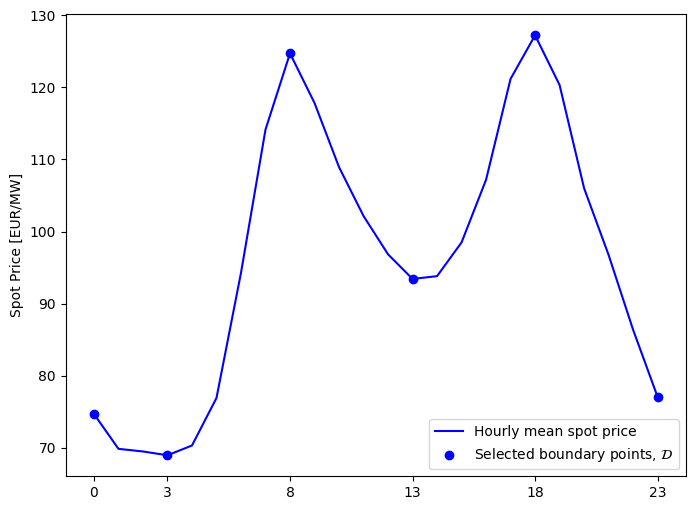

In [203]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6), dpi=100)

x_train = np.array([0, 3, 8, 13, 18, 23])
y_train = mean_spot_all_days_test[x_train]

# Plot the data
plt.plot(mean_spot_all_days_test,c='blue', label='Hourly mean spot price')
plt.scatter(x_train, y_train, c='blue', label=r"Selected boundary points, $\mathcal{D}$")
plt.ylabel("Spot Price [EUR/MW]")

# Set the x-axis ticks
plt.xticks(x_train)
plt.legend()

# Show the plot
plt.savefig('Hourly_mean_test_periode.pdf', format="pdf", bbox_inches="tight")
plt.show()


# ADDING NOISE TO CREATE THE FORECASTS

First we assess the standard deviation of the time instances of our data, because then we know how much noise we should add.


In [21]:
print(np.reshape(std_spot_all_days[x_train],(6,1)))

[[44.59919174]
 [44.33765783]
 [59.98360161]
 [45.64464177]
 [55.60187293]
 [44.49921285]]


However the standard deviation is way too much, so let us take a percentage of it. For

- D-2, 30 %
- DA, 20 %
- D-1, 10 %

In [22]:
std_train = std_spot_all_days[x_train]*0.1
noise = np.random.normal(0, std_train, std_train.shape)
print(np.shape(noise))
print(noise)

(6,)
[ 8.28166440e+00  4.38089538e-03  8.34260069e+00 -5.94981623e+00
 -9.06987647e+00 -3.53086913e+00]


In [19]:
def Forecast_of_spot(Spot_data, x_train_lst = [0,3,8,13,18,23], std_factor_increase = 0.1,deg = 6):

    '''
    Spot_data (dataframe). NEED TO BE DIVISIBLE OF 24
    x_train (list) [0,3,8,13,18,23]
    std_factor_increase (float) factor to multiply on the total standard deviation of the data
    '''

    # Load the data
    spot = Spot_data.to_numpy() # Transform to numpy
    spot_reshape = np.reshape(spot, (24, int(len(spot)/24)),order ='F') # F to ensure the correct reshaping
    mean_spot_all_days = np.mean(spot_reshape,axis=1)
    std_spot_all_days  = np.std(spot_reshape  ,axis = 1)

    # Set the training data settings
    x_train = np.array(x_train_lst) # Data which is traded upon
    X_train = x_train[:, np.newaxis] # necessary for the scikit method to work

    # Construct the noise
    std_train = std_spot_all_days[x_train]*0.2
    noise = np.random.normal(0, std_train, std_train.shape)

    # Set up the calculated parts
    True_Spot= spot_reshape 
    Forecast_no_noise = np.zeros((24,90))
    Forecast = np.zeros((24,90))


 
   # Set up settings for the Spline interpolation
    x_day = np.arange(24) # For plotting purposes
    X_day = x_day[:, np.newaxis]

    model = make_pipeline(SplineTransformer(n_knots=len(x_train_lst), degree=deg), Ridge(alpha=1e-3))

    days = len(True_Spot[0,:])
    for d in range(0,days):

        # Forecast with noise Two days prior
        y_train = True_Spot[x_train,d] + noise
        model.fit(X_train, y_train) 
        y_day = model.predict(X_day) 
        Forecast[:,d] = np.reshape(y_day, (24,) ) # Save the forecast

        # Forecast wit
        # Forecast without noise
        model.fit(X_train, spot_reshape[x_train,d]) 
        y_day = model.predict(X_day)
        Forecast_no_noise[:,d] = np.reshape(y_day, (24,) ) # Save the forecast


    
    return Forecast, Forecast_no_noise, True_Spot

In [15]:
np.size(spot_reshaped_forecasted,0)

24

In [45]:
# Array with 10 forecasts with different noise
Noise_factor = [0.1, 0.5, 1, 2, 4, 8]
# Set up an 3D array of same length as spot_reshaped_forecasted and for different forecast versions
All_spot_forecasts = np.zeros((np.size(spot_reshaped_forecasted,0),np.size(spot_reshaped_forecasted,1),np.size(Noise_factor)))
print(np.shape(All_spot_forecasts))
for n,factor in enumerate(Noise_factor):
    Forecast, Forecast_no_noise, True_Spot = Forecast_of_spot(data["Spot"].loc[(24*365):],std_factor_increase=factor,deg=3)
    print(np.shape(Forecast))
    All_spot_forecasts[:,:,n] = Forecast

    # 


(24, 90, 6)
(24, 90)
(24, 90)
(24, 90)
(24, 90)
(24, 90)
(24, 90)


Visualize the forecasts

In [47]:
d = 10
n=0
print(x_train, All_spot_forecasts[x_train,d,n])

[ 0  3  8 13 18 23] [48.98733671 31.24051031 69.3578939  70.56139831 95.46831723 40.45833399]


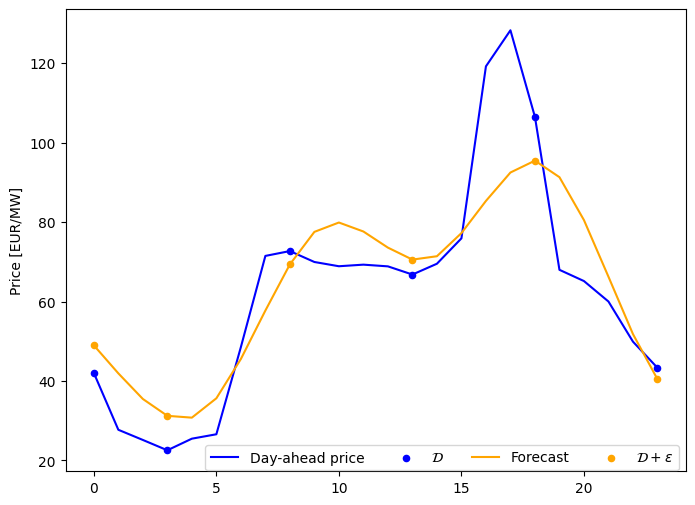

In [204]:
# Set the font size of the plot
plt.rcParams.update({'font.size': 10})

# Set the figure size and dpi
fig = plt.figure(figsize=(8, 6), dpi=100)

# Plot the data
d = 10
plt.plot(True_Spot[:,d],  label="Day-ahead price",  c='blue')
plt.scatter(x_train,True_Spot[x_train,d],  c='blue', s=20,label=r"$\mathcal{D}$")
Noise_factor = [0.1, 0.5, 1, 2, 4, 8]
Noise_name = [""]

for n,name in enumerate(Noise_name):
    legend_Name = "Forecast"+name
    plt.plot(All_spot_forecasts[:,d,n],  label=legend_Name, c='orange')
    plt.scatter(x_train, All_spot_forecasts[x_train,d,n], c='orange', s=20,label=r"$\mathcal{D} + \epsilon$")

# Add a legend outside of the plots
fig.legend(loc="lower right",bbox_to_anchor = (0.9,0.1),ncol=4)

plt.ylabel("Price [EUR/MW]")


# Show the plot
plt.savefig('Spline_interpolation_example.pdf', format="pdf", bbox_inches="tight")
plt.show()


To get above result use this website and get how it calculate it: https://tools.timodenk.com/cubic-spline-interpolation

0 37.23
3 30.24
8 69.13
13 70.56
18 95.16
23 40.45

## Summary statistics of the forecast errors

In [33]:
np.size(All_spot_forecasts[:,:,:],2)

6

In [38]:
for n in range(0,np.size(All_spot_forecasts[:,:,:],2)):
    errors = (True_Spot.flatten() - All_spot_forecasts[:,:,n].flatten())

    MAPE_h = np.abs( (True_Spot.flatten() - All_spot_forecasts[:,:,n].flatten()) / (True_Spot.flatten()) ) * 100
    MAPE = np.mean(MAPE_h)
    df_describe = pd.DataFrame(MAPE_h)
    print("Forecast ", n)
    print(df_describe.describe())
    #print(np.shape(MAPE_h))
    #print(MAPE)
    


Forecast  0
                  0
count   2160.000000
mean      40.754259
std      358.274906
min        0.002101
25%        5.182080
50%       12.017655
75%       25.602506
max    11950.649471
Forecast  1
                 0
count  2160.000000
mean     29.789055
std     301.134722
min       0.017019
25%       3.628164
50%       8.649669
75%      18.638572
max    9074.989632
Forecast  2
                  0
count   2160.000000
mean      43.387597
std      498.445875
min        0.019840
25%        5.579139
50%       11.238570
75%       22.792931
max    15923.285129
Forecast  3
                 0
count  2160.000000
mean     22.604857
std      93.011082
min       0.028902
25%       4.618344
50%      10.723771
75%      22.194659
max    2913.470596
Forecast  4
                  0
count   2160.000000
mean      47.434396
std      542.085725
min        0.038383
25%        5.277554
50%       10.913800
75%       23.029072
max    15393.540789
Forecast  5
                  0
count   2160.000000
mean  

## Percentage difference:

In [31]:
import numpy as np

avg_percentage = np.mean(np.abs(True_Spot - Forecast) / True_Spot, axis=0)
print(np.mean(avg_percentage))
for d, avg in enumerate(avg_percentage):
    print("Day", d, avg)


0.4704346710560429
Day 0 20.927759003297457
Day 1 0.0942306484453599
Day 2 0.09104462059397352
Day 3 0.06900856006383807
Day 4 0.2084455743006308
Day 5 0.12325982130472457
Day 6 0.11802524249052987
Day 7 0.4703126376215169
Day 8 0.15392930887662953
Day 9 0.08072992955140784
Day 10 0.23268002088135695
Day 11 3.166873676449154
Day 12 0.17105598687666015
Day 13 0.14239864765242416
Day 14 0.7484765078891521
Day 15 0.283892082452717
Day 16 0.11516409378076597
Day 17 0.19884643166701862
Day 18 0.056958621902173635
Day 19 0.07325381502533386
Day 20 0.12427284398807055
Day 21 0.14523659567333105
Day 22 0.08855023693539686
Day 23 0.08975140154337291
Day 24 0.07988269204643172
Day 25 0.11682429209706764
Day 26 0.06649554527195789
Day 27 0.2326876745437482
Day 28 0.2275173794206631
Day 29 0.37301016165398265
Day 30 0.21792251154933495
Day 31 0.08804103543795405
Day 32 0.1043989969069573
Day 33 0.07810450101157142
Day 34 0.12335413729643607
Day 35 0.09722515204380468
Day 36 0.08501173539638575
Day

Save it all into one dataframe:

In [33]:
True_Spot_reshaped = pd.DataFrame(np.reshape(True_Spot, (24*90,), order = 'F'),columns=["Spot"])

Forecast_reshaped = pd.DataFrame(np.reshape(Forecast, (24*90,), order = 'F'),columns=["Spot_forecast"])

# Set up FCR-D forecast. Mean for the past 5 days.
- At D-2 it is past 5 days, meaning 7 days from what to predict.
- At D-1 it is the past 5 days, meaning 6 days from what to predict

In [86]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
data = data.fillna(0) 
data_cop = data.copy()
data = data.drop(columns=["Hour"])
setup_forecast = data_cop.drop(columns=["Hour"])
True_data = data.loc[8760:].reset_index(drop=True)
True_data.columns
Spot_data = True_data['Spot']


In [87]:

Total_length_test = len(data["FD1_down"]) - 8760
# Create an empty dataframe with the same columns as `data`
forecasted_data = pd.DataFrame(columns=setup_forecast.columns, index=range(Total_length_test))
True_data = pd.DataFrame(columns=setup_forecast.columns, index=range(Total_length_test))

print(forecasted_data.columns)

Index(['Spot', 'FD1_down', 'FD2_down', 'FD1_up', 'FD2_up', 'FD1_up_percentage',
       'FD2_up_percentage', 'FD1_down_percentage', 'FD2_down_percentage',
       'FD_act_up', 'FD_act_down'],
      dtype='object')


In [88]:

D_2_list = 24*[3,4,5,6,7]
for col in data.columns:
    if col == "Spot":
        # Run spline procedure
        # Use True_data
        print("Spot started")
        Forecast_Spot, Forecast_Spot_no_noise, True_Spot = Forecast_of_spot(Spot_data)
        Forecast_Spot_reshaped = pd.DataFrame(np.reshape(Forecast_Spot, (24*90,), order = 'F'),columns=["Spot"])
        forecasted_data[col] = Forecast_Spot_reshaped
        True_Spot_reshaped = pd.DataFrame(np.reshape(True_Spot, (24*90,), order = 'F'),columns=["Spot"] )
        True_data = True_Spot_reshaped
        print("Spot ended")
    else: 
        print(col, " started")
        # Run mean procedure
        for h in range(0,Total_length_test):
            True_data.loc[h, col] = data.loc[h+8760,col]
            # As the volumes need to add up to 100% then is it only the D-1 which has been forecasted as t
            if 'percentage' in col:
                if "FD2" in col:
                    if "up" in col:
                        forecasted_data.loc[h, col] = 1 - forecasted_data.loc[h, 'FD1_up_percentage']
                    else:
                        forecasted_data.loc[h, col] = 1 - forecasted_data.loc[h, 'FD1_down_percentage']
                else:
                    forecasted_data.loc[h, col] = np.mean([data.loc[h+8760-hd, col] for hd in D_2_list])

            else:
                forecasted_data.loc[h, col] = np.mean([data.loc[h+8760-hd, col] for hd in D_2_list])
                
        print(col, " ended")

                
        

Spot started
Spot ended
FD1_down  started
FD1_down  ended
FD2_down  started
FD2_down  ended
FD1_up  started
FD1_up  ended
FD2_up  started
FD2_up  ended
FD1_up_percentage  started
FD1_up_percentage  ended
FD2_up_percentage  started
FD2_up_percentage  ended
FD1_down_percentage  started
FD1_down_percentage  ended
FD2_down_percentage  started
FD2_down_percentage  ended
FD_act_up  started
FD_act_up  ended
FD_act_down  started
FD_act_down  ended


## Plot the hourly mean method

In [205]:
h = 0
d = 3
col = 'FD1_down'
scatter_points_mean = [0*24,1*24,2*24,3*24,4*24]
forecasting_time = [5*24]
D_2_list = [3,4,5,6,7]
start_true_train = (24+h)+(8760)-(D_2_list[-1]*24) + (d*24) - 1
end_true_train = (8760 + d*24) - 24
start_true_not_used = end_true_train + 1
end_true_not_used = start_true_not_used + 24 - 1
start_true_test = end_true_not_used + 1
end_true_test = start_true_test + 24 - 1
print(start_true_train , ":", end_true_train)
print(start_true_not_used , ":", end_true_not_used)
print(start_true_test , ":", end_true_test)


# Define the x axis
total_train_points = end_true_train-start_true_train
x_train_lst = list(range(0, total_train_points  ))
x_not_used_lst = list(range(total_train_points, total_train_points+24  ))
x_test_lst = list(range(total_train_points+24, total_train_points+48  ))


# Define the data used for the plo
plot_train_data = data[col].loc[start_true_train:end_true_train].reset_index(drop=True).to_frame()
plot_not_used_data = data[col].loc[start_true_not_used:end_true_not_used].reset_index(drop=True).to_frame()
plot_true_data = data[col].loc[start_true_test:end_true_test].reset_index(drop=True).to_frame()
plot_forecasted_data = forecasted_data[col].loc[h:(24+h-1)].to_frame()

# Define the scatter plots
mean_points = plot_train_data.loc[scatter_points_mean*24]
#combine_index = plot_data.index.size()

# Define the x axis for the different plots

x_train_axis = pd.DataFrame(x_train_lst)
x_not_used_axis = pd.DataFrame(x_not_used_lst)
x_test_axis = pd.DataFrame(x_test_lst)

plot_forecasted_data = plot_forecasted_data.set_index([pd.Index(x_test_lst)])
plot_true_data = plot_true_data.set_index([pd.Index(x_test_lst)])
plot_not_used_data = plot_not_used_data.set_index([pd.Index(x_not_used_lst)])




8687 : 8808
8809 : 8832
8833 : 8856


In [206]:
x_list = x_axis.loc[scatter_points_mean].values.tolist()
y_list = plot_train_data.loc[scatter_points_mean].values.tolist()
text_list = [r'$\lambda^{\mathrm{D-7}}_{1}$', r"$\lambda^{\mathrm{D-6}}_{1}$", r"$\lambda^{\mathrm{D-5}}_{1}$", r"$\lambda^{\mathrm{D-4}}_{1}$", r"$\lambda^{\mathrm{D-3}}_{1}$"]

for x, y, text in zip(x_list, y_list, text_list):
    print(x[0],y[0],text)

0 37.73815 $\lambda^{\mathrm{D-7}}_{1}$
24 74.25043 $\lambda^{\mathrm{D-6}}_{1}$
48 122.61244 $\lambda^{\mathrm{D-5}}_{1}$
72 0.0 $\lambda^{\mathrm{D-4}}_{1}$
96 945.65862 $\lambda^{\mathrm{D-3}}_{1}$


[0] [37.73815] $\lambda^{\mathrm{D-7}}_{1}$
[24] [74.25043] $\lambda^{\mathrm{D-6}}_{1}$
[48] [122.61244] $\lambda^{\mathrm{D-5}}_{1}$
[72] [0.0] $\lambda^{\mathrm{D-4}}_{1}$
[96] [945.65862] $\lambda^{\mathrm{D-3}}_{1}$


c:\Users\Daniel  BV\Desktop\Thesis\lightenup\venv\lib\site-packages\matplotlib\text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\venv\lib\site-packages\matplotlib\text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\venv\lib\site-packages\matplotlib\text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\venv\lib\site-packages\matplotlib\text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a Type

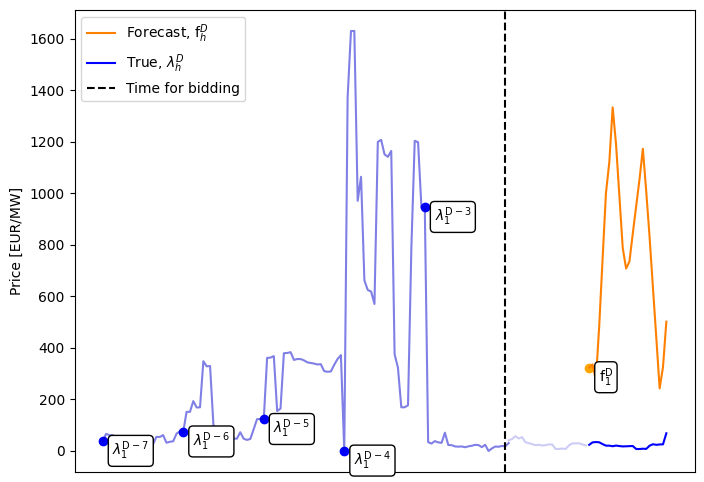

In [207]:
# Define RGB values for different shades of blue
blue_shades = [
    (0, 0, 1),        # Pure blue
    (0.4, 0.4, 1),    # Lighter blue
    (0, 0, 0.8),      # Darker blue
]

orange_shades = [
    (1, 0.5, 0),       # Pure orange
    (1, 0.7, 0.2),     # Lighter orange
    (0.8, 0.4, 0),     # Darker orange
]

# Set the figure size and dpi
fig = plt.figure(figsize=(8, 6), dpi=100)

plt.plot(plot_train_data,c=blue_shades[2],alpha=0.5)
plt.plot(plot_forecasted_data, label=r"Forecast, f$^{D}_h$",c=orange_shades[0])
plt.plot(plot_not_used_data,c=blue_shades[2],alpha=0.2)
plt.plot(plot_true_data, label="True, $\lambda^{D}_h$", c="blue")

# only one line may be specified; full height
plt.axvline(x=forecasting_time, color='black', linestyle='--',label= "Time for bidding")

# Scatter plot with custom text annotations and boxes
for x, y, text in zip(x_list, y_list, text_list):
    print(x,y,text)
    plt.scatter(x[0],y[0],c="blue")
    plt.annotate(text, (x[0],y[0]), xytext=(7, -10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))

plt.scatter(x_test_axis.iloc[0], plot_forecasted_data.iloc[0],c="orange")
plt.annotate(r"f$^{\mathrm{D}}_{1}$", (x_test_axis.iloc[0],plot_forecasted_data.iloc[0]), xytext=(7, -10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black'))
# Remove x-axis tick marks and labels
plt.xticks([])

# Add a legend outside of the plots
plt.legend(loc="upper left")

plt.ylabel("Price [EUR/MW]")

# Show the plot
plt.savefig('Hourly_mean_forecast.pdf', format="pdf", bbox_inches="tight")
plt.show()


# Quantify the predictability of the forecasts

Create a histogram of the precision
Remove all true values which are 0.

In [130]:
x = np.array([2, 1, 3, np.inf, 5, 2, 3, np.inf])
m = np.ma.masked_array(x, np.isnan(x))
print(m)
m2 = np.ma.masked_array(x, np.isinf(x))
print(m2.sum())


[2.0 1.0 3.0 inf 5.0 2.0 3.0 inf]
16.0


In [171]:

d = 1
start = 18
end = 19
Percentage_data = pd.DataFrame(columns=['Spot', 'FD1_down', 'FD2_down', 'FD1_up', 'FD2_up'], index=range(Total_length_test))
print(forecasted_data.shape)
print(True_data.shape)
print(Total_length_test)
for col in ['Spot', 'FD1_down', 'FD2_down', 'FD1_up', 'FD2_up']:
    
    # why inf.....
    indexes = np.where(True_data[col] != 0)[0] # Index to NOT remove
    pred = forecasted_data[col]#.loc[indexes].values
    
    true = True_data[col] #.loc[indexes].values
    #pred = forecasted_data[col].loc[indexes].values
    
    #true = True_data[col].loc[indexes].values
    AE =  (np.abs(true - pred) / true )
    Percentage_data[col] = AE.replace(np.inf, 0) # Set all the ones that are inf to 0
    Percentage_data[col] = Percentage_data[col].replace(0,np.mean(Percentage_data[col]))
    

    print((AE[(start+d*24):(end+d*24)]))
    print((Percentage_data[col].loc[(start+d*24):(end+d*24)]))
 


(2160, 11)
(2160, 11)
2160
42    0.051336
Name: Spot, dtype: float64
42    0.051336
43    0.118073
Name: Spot, dtype: float64
42    inf
Name: FD1_down, dtype: object
42    0.824365
43    1.010258
Name: FD1_down, dtype: float64
42    0.040063
Name: FD2_down, dtype: object
42    0.040063
43     0.04949
Name: FD2_down, dtype: object
42    0.012681
Name: FD1_up, dtype: object
42    0.012681
43    0.020685
Name: FD1_up, dtype: float64
42    0.028325
Name: FD2_up, dtype: object
42    0.028325
43    0.017315
Name: FD2_up, dtype: object


In [184]:
# Reshape dataframe
print(Percentage_data.to_numpy())
Percentage_data_arr = Percentage_data.to_numpy()
Percentage_data_reshape = Percentage_data_arr.reshape(90,24,-1)
print(Percentage_data_reshape.shape)
print(np.isnan(np.min(Percentage_data_reshape)))

[[1.1371876595800998 0.764322483603879 0.395087431603084
  0.630905768136374 0.07299323867491808]
 [0.3798884926945477 0.7938799135729084 0.4281999257311821
  0.5917972228781014 0.0687960273077938]
 [7.861899725158868 0.8316076019950909 0.40342789571378374
  0.5814046156718566 0.06373869495023113]
 ...
 [0.9991026480504436 0.28702328246723813 0.00585628245973911
  0.0029257085511821546 0.026170202565908768]
 [0.6124644885428596 0.19428241659633683 0.006118656432222172
  0.009056697464432897 0.03171763686839904]
 [0.06019260344208334 0.09063404517045812 0.007303567658396666
  0.015833038349164733 0.02450615996682327]]
(90, 24, 5)
False


In [180]:
# Check if it has reshaped correctly:
d = 89
start = 0
end = 24
print(Percentage_data_arr[(start+d*24):(end+d*24),1])
print(Percentage_data_reshape[d,start:end,1])
# It is correct!

[0.7686190201803552 0.8224198663925726 0.8206539319268263
 0.26435015829686015 0.12388750204895654 0.3626286737167785
 0.6834963589353125 0.8783616716839484 1.8403151510352505
 2.2505077738452184 1.4936349563899174 1.28806287743695 1.0759644858664248
 0.7004877885243979 0.09470868541369204 0.2718883519708179
 0.24966925142514876 0.08722539543057975 0.2277184752569113
 0.2296993684174717 0.3007960376999877 0.28702328246723813
 0.19428241659633683 0.09063404517045812]
[0.7686190201803552 0.8224198663925726 0.8206539319268263
 0.26435015829686015 0.12388750204895654 0.3626286737167785
 0.6834963589353125 0.8783616716839484 1.8403151510352505
 2.2505077738452184 1.4936349563899174 1.28806287743695 1.0759644858664248
 0.7004877885243979 0.09470868541369204 0.2718883519708179
 0.24966925142514876 0.08722539543057975 0.2277184752569113
 0.2296993684174717 0.3007960376999877 0.28702328246723813
 0.19428241659633683 0.09063404517045812]


[[0.87425539 0.89099939 0.91192522 ... 0.89284603 0.80954066 0.68501962]
 [4.42529369 5.38256196 5.05453961 ... 0.19540126 0.51179404 0.53114095]
 [0.74797802 0.83414453 0.80378183 ... 0.77906914 0.79269988 0.62935553]
 ...
 [0.25457407 0.18181651 0.10432705 ... 0.41408617 0.41797814 0.43231996]
 [0.31127553 0.25649235 0.21516202 ... 0.40465515 0.36022339 0.45414123]
 [0.8767092  0.90687368 0.90589952 ... 0.53574554 0.44077479 0.30105489]]


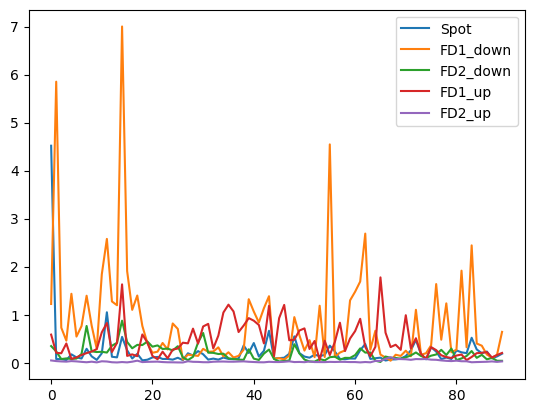

In [194]:
forecastName = ['Spot', 'FD1_down', 'FD2_down', 'FD1_up', 'FD2_up']
print(np.sqrt(Percentage_data_reshape[:,:,1].astype(float)))

x = np.arange(0,90) # Test days

for forecast in range(0,len(forecastName)):
    dailyMean = np.mean(Percentage_data_reshape[:,:,forecast].astype(float),axis=1)
    dailyStd = np.std(Percentage_data_reshape[:,:,forecast].astype(float),axis=1)

    plt.plot(x,dailyMean,label = forecastName[forecast])

plt.legend()
    



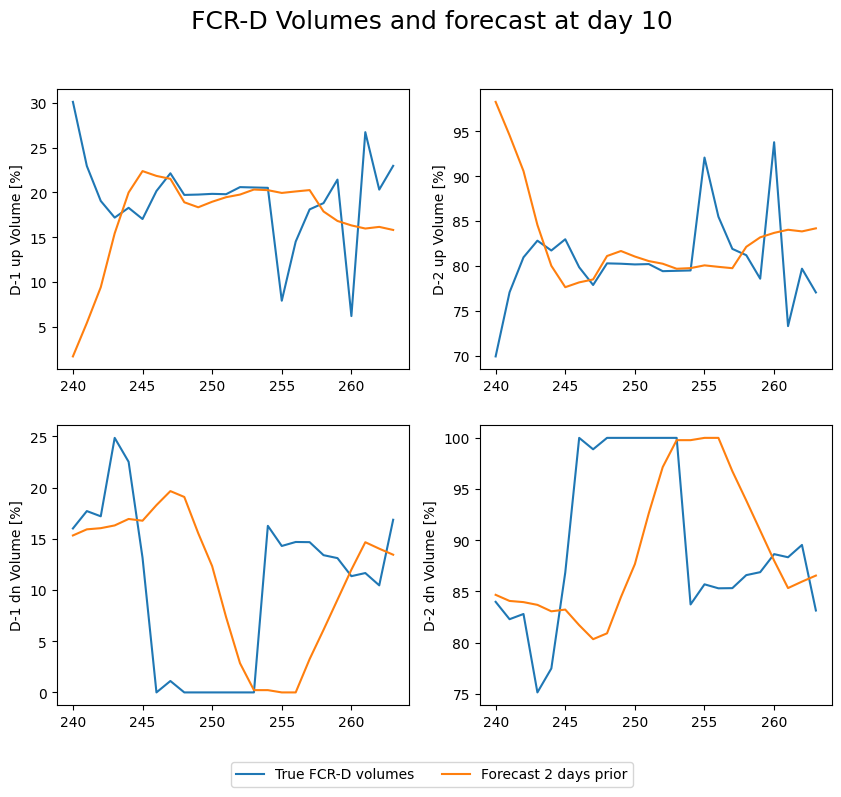

In [42]:
True_FCRD_vol = data[["FD1_down_percentage","FD2_down_percentage","FD1_up_percentage","FD2_up_percentage"]].loc[8760:].reset_index(drop=True)


fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=100)
d = 10
for i, col in enumerate(True_FCRD_vol.columns):
    ax = axs[i // 2, i % 2]
    ax.plot(True_FCRD_vol[col].iloc[int(0+float(d)*24):int(24+float(d)*24)]*100, label="True FCR-D volumes")
    ax.plot(forecasted_data[col].iloc[int(0+float(d)*24):int(24+float(d)*24)]*100, label="Forecast 2 days prior")
    ax.set_ylabel(col)

axs[0,0].set_ylabel('D-1 up Volume [%]') 
axs[0,1].set_ylabel('D-2 up Volume [%]') 
axs[1,0].set_ylabel('D-1 dn Volume [%]') 
axs[1,1].set_ylabel('D-2 dn Volume [%]') 


# Add a legend outside of the plots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.001), ncol=3)

# Set the plot title
title = "FCR-D Volumes and forecast at day {}".format(d)
fig.suptitle(title, fontsize=18)

# Show the plot
plt.show()
fig.savefig('FCR-D_Forcasts_volumes.png')

In [ ]:
import seaborn as sns

# Sample data
data = df["Spot"]

# Set up seaborn style
sns.set(style="whitegrid")

# Create histogram
sns.histplot(data, kde=True, color='skyblue')

# Add labels and title
plt.xlabel('Frequency [Hz]')
plt.ylabel('Occurences')

# Show the plot
plt.show()


In [ ]:
True_FCRD = data[["FD1_down","FD2_down","FD1_up","FD2_up"]].loc[8760:].reset_index(drop=True)

fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=100)
d = 10
for i, col in enumerate(True_FCRD.columns):
    ax = axs[i // 2, i % 2]
    ax.plot(True_FCRD[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="True FCR-D prices")
    ax.plot(forecasted_data_D_2[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="Forecast 2 days prior")
    ax.plot(forecasted_data_D_1[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="Forecast 1 day prior")
    ax.set_ylabel(col)

axs[0,0].set_ylabel('D-1 up price [EUR/MW]') 
axs[0,1].set_ylabel('D-2 up price [EUR/MW]') 
axs[1,0].set_ylabel('D-1 dn price [EUR/MW]') 
axs[1,1].set_ylabel('D-2 dn price [EUR/MW]') 


# Add a legend outside of the plots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.001), ncol=3)

# Set the plot title
title = "FCR-D prices and forecast at day {}".format(d)
fig.suptitle(title, fontsize=18)

# Show the plot
plt.show()
fig.savefig('FCR-D_Forcasts_prices.png')

In [ ]:
True_act = data[["FD_act_up","FD_act_down"]].loc[8760:].reset_index(drop=True)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), dpi=100)
d = 10
for i, col in enumerate(True_act.columns):
    ax = axs[i]
    ax.plot(True_act[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="True activation")
    ax.plot(forecasted_data_D_2[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="Forecast 2 days prior")
    ax.plot(forecasted_data_D_1[col].iloc[int(0+float(d)*24):int(24+float(d)*24)], label="Forecast 1 day prior")
    ax.set_ylabel(col)

axs[0].set_ylabel('D-1 up price [EUR/MW]')  
axs[1].set_ylabel('D-1 dn price [EUR/MW]')


# Add a legend outside of the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.001), ncol=3)

# Set the plot title
title = "Activation and forecast at day {}".format(d)
fig.suptitle(title, fontsize=18)

# Show the plot
plt.show()
fig.savefig('Activation_Forecasts.png')

# Create a csv file for forecasted values of D-2

In [ ]:

forecasted_data_D_2 = forecasted_data_D_2
Forecast_Spot_D_2_reshaped = pd.DataFrame(np.reshape(Forecast_Spot_D_2, (24*90,), order = 'F'),columns=["Spot"])
print(forecasted_data_D_2.columns)
print(Forecast_Spot_D_2_reshaped.columns)
forecast_D_2_comb = pd.concat([Forecast_Spot_D_2_reshaped, forecasted_data_D_2], axis=1)
print(forecast_D_2_comb.shape)
print(forecast_D_2_comb.columns)

#Create csv
forecast_D_2_comb.to_csv("forecast.csv",index=False)